In [226]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression

In [227]:
NUM_DAYS = 10000    
INTERVAL = '1d'     
symbol = 'RTY=F'

[*********************100%***********************]  1 of 1 completed
1132
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-07-10  1416.400024  1419.300049  1403.699951  1408.699951  1408.699951   
2017-07-11  1408.599976  1414.099976  1400.000000  1413.099976  1413.099976   
2017-07-12  1413.500000  1432.800049  1411.599976  1422.599976  1422.599976   
2017-07-13  1422.800049  1426.000000  1413.800049  1425.800049  1425.800049   
2017-07-14  1425.699951  1433.300049  1420.800049  1428.599976  1428.599976   

            Volume  
Date                
2017-07-10    2658  
2017-07-11    5843  
2017-07-12    5998  
2017-07-13    4203  
2017-07-14    4915  


<AxesSubplot:xlabel='Date'>

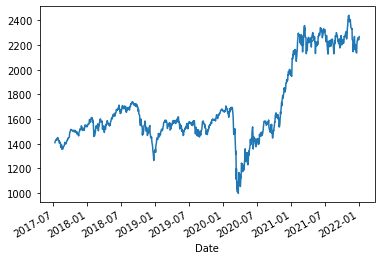

In [228]:
start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)

print(len(data))

print(data.head())

data["Close"].plot()

<AxesSubplot:xlabel='Date'>

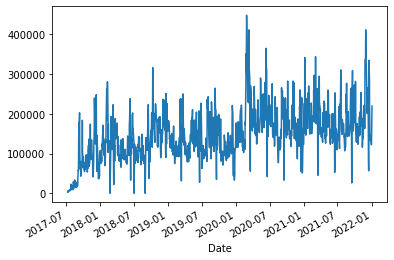

In [229]:
data["Volume"].plot()

<AxesSubplot:xlabel='Date'>

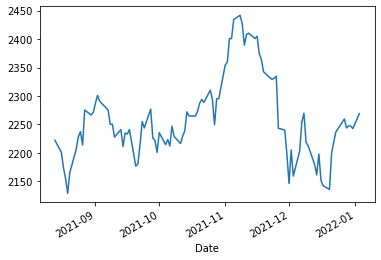

In [230]:
data.iloc[-100:]['Close'].plot()

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-07-10  1416.400024  1419.300049  1403.699951  1408.699951  1408.699951   
2017-07-11  1410.622210  1415.448143  1400.959247  1411.959229  1411.959229   
2017-07-12  1412.576567  1427.232120  1408.185548  1419.185542  1419.185542   
2017-07-13  1419.323070  1426.419041  1411.890572  1423.550473  1423.550473   
2017-07-14  1423.489928  1430.915311  1417.712309  1426.849979  1426.849979   

                 Volume  
Date                     
2017-07-10  2658.000000  
2017-07-11  5017.259259  
2017-07-12  5683.297114  
2017-07-13  4706.445104  
2017-07-14  4842.721536  


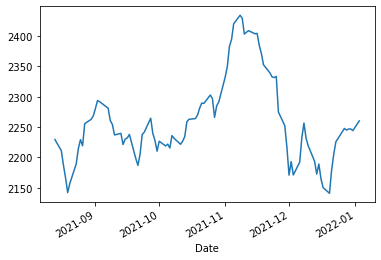

In [231]:
data = data.ewm(alpha=0.65).mean()
data = data.dropna()

data.iloc[-100:]['Close'].plot()

print(data.head())

In [232]:
live_pred_data = data.iloc[-100:-10]
live_pred_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-13,2243.529157,2247.029214,2220.618150,2229.545209,2229.545209,122563.464256
2021-08-16,2226.285205,2230.175288,2199.286384,2211.250760,2211.250760,149469.262489
2021-08-17,2209.849822,2211.926414,2166.015298,2187.297702,2187.297702,214473.641871
2021-08-18,2184.987501,2198.519277,2151.445418,2166.304196,2166.304196,206425.574655
2021-08-19,2161.465657,2172.636715,2123.660864,2142.121532,2142.121532,252101.351129
...,...,...,...,...,...,...
2021-12-13,2217.620689,2236.862406,2179.879145,2193.716333,2193.716333,253468.040356
2021-12-14,2196.157304,2209.846874,2162.017637,2172.645748,2172.645748,189491.764125
2021-12-15,2175.450088,2204.681342,2141.271237,2189.191075,2189.191075,120450.867444


In [233]:
def _produce_prediction(data, window):
    
    prediction = (data.shift(-window)['Close'] >= data['Close'])
    prediction = prediction.iloc[:-window]
    data['Pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['Close'])
data = data.dropna()
data.tail()
print(len(data))

print(data)


1117
                   Open         High          Low    Adj Close         Volume  \
Date                                                                            
2017-07-10  1416.400024  1419.300049  1403.699951  1408.699951    2658.000000   
2017-07-11  1410.622210  1415.448143  1400.959247  1411.959229    5017.259259   
2017-07-12  1412.576567  1427.232120  1408.185548  1419.185542    5683.297114   
2017-07-13  1419.323070  1426.419041  1411.890572  1423.550473    4706.445104   
2017-07-14  1423.489928  1430.915311  1417.712309  1426.849979    4842.721536   
...                 ...          ...          ...          ...            ...   
2021-12-06  2178.374486  2222.095850  2147.177777  2192.246938  279788.877988   
2021-12-07  2197.566007  2256.028579  2182.617190  2232.321365  239350.507296   
2021-12-08  2239.513166  2271.544939  2222.450953  2256.682509  214117.827554   
2021-12-09  2258.679608  2273.205792  2217.217770  2231.798815  247622.839644   
2021-12-10  2232.887863

In [234]:
y = data['Pred']
features = [x for x in data.columns if x not in ['Pred']]
X = data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.33)

In [235]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test.values, rf_prediction)
print('Random Forest Classifier Accuracy = ' , rf_accuracy , "\n")
print(classification_report(y_test, rf_prediction))

Random Forest Classifier Accuracy =  0.7276368491321762 

              precision    recall  f1-score   support

         0.0       0.65      0.61      0.63       283
         1.0       0.77      0.80      0.78       466

    accuracy                           0.73       749
   macro avg       0.71      0.70      0.71       749
weighted avg       0.72      0.73      0.73       749



In [236]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
knn_prediction = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test.values, knn_prediction)
print('KNeighbors Classifier Accuracy = ' , knn_accuracy , "\n")
print(classification_report(y_test, knn_prediction))
confusion_matrix_graph = confusion_matrix(y_test, knn_prediction)

KNeighbors Classifier Accuracy =  0.5861148197596796 

              precision    recall  f1-score   support

         0.0       0.42      0.26      0.32       283
         1.0       0.64      0.79      0.70       466

    accuracy                           0.59       749
   macro avg       0.53      0.52      0.51       749
weighted avg       0.55      0.59      0.56       749



In [237]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_prediction = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test.values, lr_prediction)
print('Logistic Regression Classifier Accuracy = ' , lr_accuracy , "\n")
print(classification_report(y_test, lr_prediction))

Logistic Regression Classifier Accuracy =  0.6248331108144193 

              precision    recall  f1-score   support

         0.0       0.56      0.03      0.06       283
         1.0       0.63      0.98      0.77       466

    accuracy                           0.62       749
   macro avg       0.59      0.51      0.41       749
weighted avg       0.60      0.62      0.50       749

